In [3]:
import pandas as pd
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
from moviepy.video.io.VideoFileClip import VideoFileClip
import librosa
import moviepy.editor as mp
import numpy as np
import matplotlib.pyplot as plt


In [4]:
train_video_folder = "/Users/kj/Desktop/Research Project/Train videos"
train_data = pd.read_csv("/Users/kj/Desktop/Research Project/Data set/train.csv")
train_video_names = train_data["YouTube ID"].unique()

In [5]:
train_data = train_data[::25]

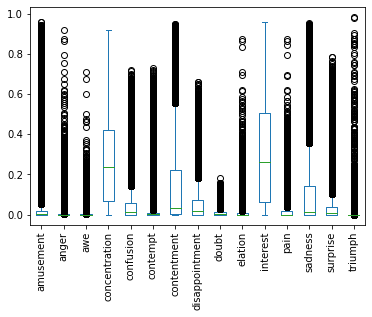

In [6]:
train_data.iloc[:,2:].plot(kind="box")
plt.xticks(rotation=90)
plt.show()

In [7]:
print(train_data.quantile(0.90)[2:])

anger             0.008333
awe               0.005665
concentration     0.582638
confusion         0.121627
contempt          0.043919
contentment       0.474709
disappointment    0.175334
doubt             0.020537
elation           0.027558
interest          0.701466
pain              0.080016
sadness           0.416372
surprise          0.101754
triumph           0.000728
Name: 0.9, dtype: float64


In [8]:
if not os.path.exists("Train_Images"):
    os.mkdir("Train_Images")

In [9]:
top_ten_percent = train_data.quantile(0.90)

In [10]:
emotions = ["concentration","confusion","contentment","interest","sadness"]
final_train_data = pd.DataFrame(columns=["image","concentration","confusion","contentment","interest","sadness"])

In [11]:
final_train_data

,image,concentration,confusion,contentment,interest,sadness


In [12]:
def add_noise_to_audio(audio_array, noise_level=0.01):
    # Generate random noise and add it to the audio array
    noise = np.random.normal(0, noise_level, len(audio_array))
    noisy_audio = audio_array + noise[:, np.newaxis] 
    return noisy_audio

def extract_spectrogram(audio, fps, timestamp_ms, noise=True, noise_level=0.01):
    # Convert timestamp from microseconds to seconds
    timestamp_sec = timestamp_ms / 1000000.0

    # Define the time range for audio extraction
    start_ts = max(0, timestamp_sec - 5)
    end_ts = timestamp_sec

    # Extract audio within the time range
    audio = audio.subclip(start_ts, end_ts)
    audio_array = audio.to_soundarray(fps=fps)
    if noise:
        # Add noise to the audio array
        audio_array = add_noise_to_audio(audio_array, noise_level)

    # Calculate the spectrogram
    spectrogram = librosa.amplitude_to_db(librosa.stft(audio_array), ref=np.max)
    return spectrogram

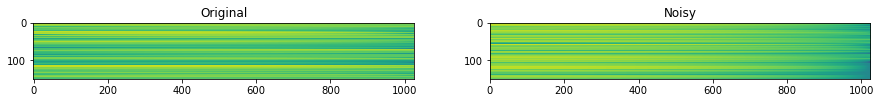

In [14]:
video_path = "/Users/kj/Desktop/Research Project/Train videos/_29dg6_e3fs/Lil DM3 - 23 (Offical Music Video) Shot by Flexx Productions.mp4"
# Load the video and get its FPS
video = cv2.VideoCapture(video_path)
fps = np.ceil(video.get(cv2.CAP_PROP_FPS))

# Load the audio from the video
video_vfc = mp.VideoFileClip(video_path)
audio = video_vfc.audio
time_stamp = 6000000
original_audio = extract_spectrogram(audio, fps, time_stamp,noise = False)
noise_audio = extract_spectrogram(audio, fps, time_stamp,noise = True, noise_level=0.2)


# Create a figure with 3 subplots arranged in a 1x3 grid
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Plot data on the first subplot
axs[0].imshow(original_audio)
axs[0].set_title('Original')

# Plot data on the second subplot
axs[1].imshow(noise_audio)
axs[1].set_title('Noisy')

plt.show()

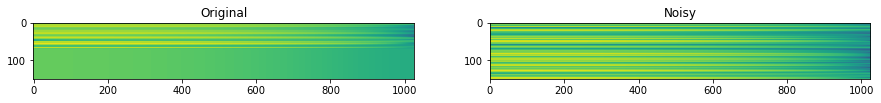

In [15]:
video_path = "/Users/kj/Desktop/Research Project/Train videos/_29dg6_e3fs/Lil DM3 - 23 (Offical Music Video) Shot by Flexx Productions.mp4"
# Load the video and get its FPS
video = cv2.VideoCapture(video_path)
fps = np.ceil(video.get(cv2.CAP_PROP_FPS))

# Load the audio from the video
video_vfc = mp.VideoFileClip(video_path)
audio = video_vfc.audio
time_stamp = 120000000
original_audio = extract_spectrogram(audio, fps, time_stamp,noise = False)
noise_audio = extract_spectrogram(audio, fps, time_stamp,noise = True, noise_level=0.2)


# Create a figure with 3 subplots arranged in a 1x3 grid
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Plot data on the first subplot
axs[0].imshow(original_audio)
axs[0].set_title('Original')

# Plot data on the second subplot
axs[1].imshow(noise_audio)
axs[1].set_title('Noisy')

plt.show()

In [23]:
# Loop through first 500 video names in train_video_names
for cur_name in train_video_names[0:500]:
    # Check if the video exists
    if os.path.exists("Train_Videos/{}".format(cur_name)):
        print("Extracting Frames from {}".format(cur_name))

        # Get the name and path of the video
        video_name = os.listdir("Train_Videos/{}".format(cur_name))[0]
        video_path = "Train_Videos/{}/{}".format(cur_name, video_name)

        # Load the video and get its FPS
        video = cv2.VideoCapture(video_path)
        fps = np.ceil(video.get(cv2.CAP_PROP_FPS))
        
        # Load the audio from the video
        video_vfc = mp.VideoFileClip(video_path)
        audio = video_vfc.audio
            
        # Get the subset of train_data for the current video
        sub_data = train_data[train_data["YouTube ID"] == cur_name]
        sub_data.reset_index(inplace=True, drop=True)

        # Loop through each timestamp and extract frames and spectrograms
        for idx, time_stamp in enumerate(sub_data["Timestamp (milliseconds)"]):
            ts = time_stamp / 1000.0

            # Skip frames within the first 5 seconds
            if time_stamp / 1000000.0 <= 5:
                continue
            else:
                # Get the emotion label with the highest score
                frame_emotion = sub_data.columns[np.argmax(sub_data.iloc[idx][2:]) + 2]

                # Check if the frame emotion is valid and above the threshold
                if frame_emotion in emotions and sub_data.iloc[idx][frame_emotion] >= top_ten_percent[frame_emotion]:
                    video.set(cv2.CAP_PROP_POS_MSEC, ts)
                    ret, frame = video.read()

                    if ret:
                        # Save the frame and spectrogram as an image
                        image_name = "Train_Images/" + cur_name + "_" + str(idx) + ".jpg"
                        spectrogram = extract_spectrogram(audio, fps, time_stamp)
                        spectrogram = cv2.resize(spectrogram, (frame.shape[1], spectrogram.shape[0]))
                        spectrogram = cv2.applyColorMap(spectrogram.astype(np.uint8), cv2.COLORMAP_VIRIDIS)
                        image = cv2.vconcat([frame, spectrogram])
                        cv2.imwrite(image_name, image)

                        # Append data to the final_train_data DataFrame
                        tep_df = pd.DataFrame(columns=final_train_data.columns, data=[[image_name] + list(sub_data.iloc[idx][emotions].values)])
                        final_train_data = final_train_data.append(tep_df, ignore_index=True)
                    else:
                        print("Error! Retrieving Frame at {} ms".format(time_stamp))
                else:
                    print("Frame Does not Match Criteria!")


In [24]:
final_train_data.to_csv("KJ.csv",index=False)